In [1]:
import warnings
warnings.filterwarnings('ignore')

import sympy as sym
import numpy as np
from scipy.optimize import linprog

from prettytable import PrettyTable

## Пояснения за алгоритм

На каждой итерации метода строится возможное направление спуска с помощью некоторой вспомогательной задачи, которая обычно является задачей линейного программирования, и затем проводится оптимизация вдоль этого направления.

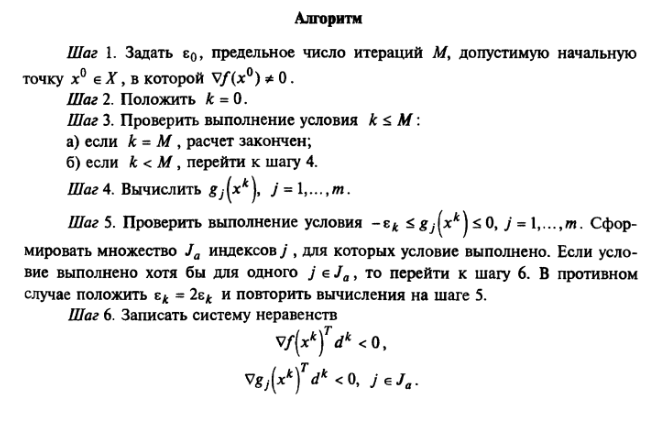
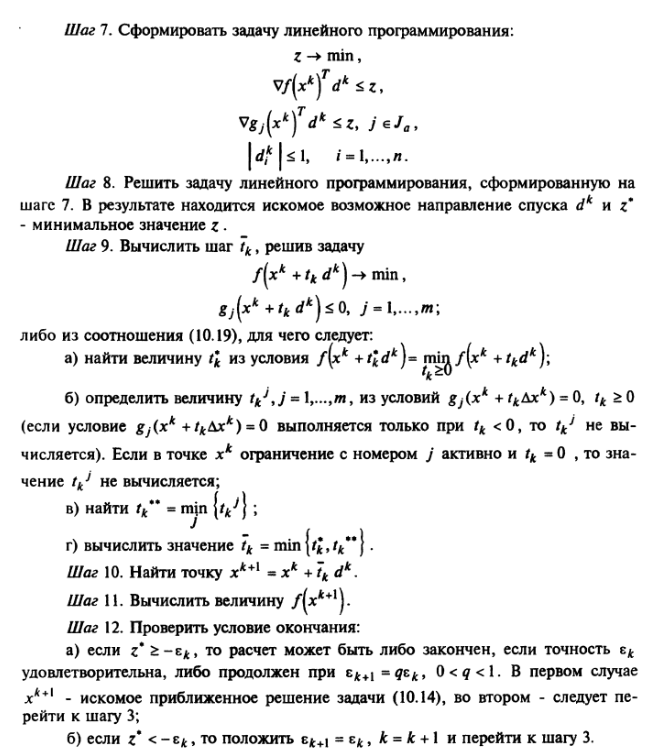

К слову, если численно расписать решение симплекс-методом 7 шага этого примера, то будет выглядеть так:

In [7]:
L = [0, 0, 1]
lhs_ineq = [[-8, -8.1, -1],
            [-1, 0, -1],
            [1, 0, 0],
            [-1, 0, 0],
            [0, 1, 0],
            [0, -1, 0]]
rhs_ineq = [0, 0, 1, 1 , 1, 1]

opt = linprog(c=L, A_ub=lhs_ineq, b_ub=rhs_ineq, method="simplex")
opt

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.0
       x: [ 1.000e+00  1.000e+00  0.000e+00]
     nit: 4

##  МЕТОДЫ ВОЗМОЖНЫХ НАПРАВЛЕНИЙ. Метод Зойтендейка

In [2]:
# просто красивая таблица
table = PrettyTable(['N',  'x_n', 'y_n', 'f(x_n, y_n)', 'z'])
td = []

# переменные
variables = x1, x2 = sym.symbols('x1 x2')
n = len(variables)

# целевая функция
f = (x1 - 4)**2 + (x2-5)**2

# ЛИНЕЙНЫЕ ограничения
g1 = x1 + x2 - 1
g2 = -x1
g3 = -x2
g_1 = np.array([g1, g2, g3])

# НЕЛИНЕЙНЫЕ ограничения
g1 = x2**2 + x1 - 1
g2 = -x1
g3 = -x2
g_2 = np.array([g1, g2, g3])

# допустимая начальная точка, в которой ∇f(x0) != 0
x0 = np.array([0, 0.95])

eps = 0.03

In [3]:
def value(f, x):
    '''значение функции sympy в точке'''
    return f.evalf(subs=dict(zip(variables, x)))

def restrictions_on_d(n):
    '''ограничения |d_i| <= 1, i=1,..,n
       + еще один столбец для переменной z (функции, которая -> min)'''
    result = []
    for i in range(n):
        row = [0] * (n + 1)
        row[i] = 1
        result.append(row)
        result.append([-x for x in row])
    return result

def gradient_from_point(f, x):
    '''вычисление градиента функции f в точке х'''
    gradients_f = [sym.diff(f, variable) for variable in variables]
    return [value(grad, x) for grad in gradients_f]

In [4]:
def zoitendeika(f, g, eps, x0):
    x = x0
    n_iter = 0
    z = - 10**5
    t = sym.symbols('t')

    table = PrettyTable(['N',  'x_n', 'y_n', 'f(x_n, y_n)', 'z'])
    td = [[n_iter, x[0], x[1], value(f, x), z]]

    while (z < -eps):
        # расчет активных ограничений (шаг 4-5)
        active_g = [g_x for g_x in g if (-eps <= value(g_x, x) <= 0)]
        if len(active_g) == 0: 
            eps *= 2
            continue

        ### решение задачи линейного программирования с нормирующим ограничением (шаг 6-8) ^ пояснение выше ^

        # целевая функция L = z -> min
        L = [0]*n + [-1]
        # левая часть неравенств = огранич. в собственном смысле + ограничения на возможные ограничения спуска
        limits_for_funcs = [gradient_from_point(func, x) + [-1] for func in [f] + active_g]
        limits_for_dirs = restrictions_on_d(n)
        limits = limits_for_funcs + limits_for_dirs
        # правая часть неравенств (то, что стоит после <=)
        values_limits = [0]*len(limits_for_funcs)+[1]*len(limits_for_dirs)
        # вычисление d и z симплекс-методом, где 
        # d - возможное направление спуска
        # z - величина >= градиента в текущей точке * d (идеал значения - 0)
        *d, z = linprog(c=L, A_ub=limits, b_ub=values_limits, method="simplex").x
        d = np.array(d)

        ###  решение задачи одномерной минимизации для вычисления шага по направлению (шаг 9)

        # список для записи t
        steps = []
        # решение f(x + t*d) -> min через производную
        diff_f_t = sym.diff(value(f, x + t*d), t)
        root = sym.solve(diff_f_t, t)[0] # не факт, что он один, зависит от функции :)
        steps.append(root) if root >= 0 else None
        # вычисление g_i(x + t*d) = 0 (i = 1,n) при некоторых условиях
        for i in range(len(g)):
            roots = sym.solve(value(g[i], x + t*d), t)
            positive_root = list(filter(lambda x: x >= 0, roots))
            if not(len(positive_root) == 0 or (g[i] in active_g and positive_root[0] == 0)):
                steps.append(positive_root[0]) 
        
        ### обновление точки минимума (шаг 10)
        x = x + min(steps)*d
        
        n_iter += 1
        td.append([n_iter, x[0], x[1], value(f, x), z])

    for i in range(len(td)):
        table.add_row([round(float(x), 5) for x in td[i]])

    return table, x

Случай линейных ограничений:

In [5]:
table_1, answer_1 = zoitendeika(f, g_1, eps, x0)

print(table_1)
print(f"\n\nМинимальное значение в точке: ({float(answer_1[0]):3f}, {float(answer_1[1]):3f}, {float(value(f, answer_1)):3f})")

+-----+-------+-------+-------------+-----------+
|  N  |  x_n  |  y_n  | f(x_n, y_n) |     z     |
+-----+-------+-------+-------------+-----------+
| 0.0 |  0.0  |  0.95 |   32.4025   | -100000.0 |
| 1.0 | 0.025 | 0.975 |   32.00125  |    0.0    |
+-----+-------+-------+-------------+-----------+


Минимальное значение в точке: (0.025000, 0.975000, 32.001250)


Случай НЕлинейных ограничений:

In [6]:
table_2, answer_2 = zoitendeika(f, g_2, eps, x0)

print(table_2)
print(f"\n\nМинимальное значение в точке: ({float(answer_2[0]):3f}, {float(answer_2[1]):3f}, {float(value(f, answer_2)):3f})")

+-----+---------+---------+-------------+-----------+
|  N  |   x_n   |   y_n   | f(x_n, y_n) |     z     |
+-----+---------+---------+-------------+-----------+
| 0.0 |   0.0   |   0.95  |   32.4025   | -100000.0 |
| 1.0 | 0.03324 | 0.98324 |   31.86955  |    0.0    |
+-----+---------+---------+-------------+-----------+


Минимальное значение в точке: (0.033240, 0.983240, 31.869551)
